<a href="https://colab.research.google.com/github/shreeya-la/audio-ml/blob/main/yamnet_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and Download ESC50

In [1]:
#!pip install tensorflow --upgrade

In [2]:
# !pip uninstall tensorflow
# !pip uninstall tensorflow-io

In [37]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report

In [23]:
!test ! -f "master.zip" && wget "https://github.com/karoldvl/ESC-50/archive/master.zip"

--2024-09-26 18:25:42--  https://github.com/karoldvl/ESC-50/archive/master.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/karolpiczak/ESC-50/archive/master.zip [following]
--2024-09-26 18:25:42--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2024-09-26 18:25:42--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.github.com (codeload.github.com)|140.82.113.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [     

In [24]:
!unzip -qq master.zip
%cd ESC-50-master

[master.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of master.zip or
        master.zip.zip, and cannot find master.zip.ZIP, period.


In [25]:
# create a dataframe
esc50_data = pd.read_csv('meta/esc50.csv')
esc50_data.head()

[Errno 2] No such file or directory: 'ESC-50-master'
/content/ESC-50-master


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [16]:
animals = ['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow']
map_class_to_id = {'dog':0,'rooster':1, 'pig':2, 'cow':3, 'frog':4, 'cat':5, 'hen':6, 'insects':7, 'sheep':8, 'crow':9}

esc50_animals = esc50_data[esc50_data.category.isin(animals)]
class_id = esc50_animals['category'].apply(lambda name: map_class_to_id[name])
esc50_animals = esc50_animals.assign(target=class_id)

esc50_animals.head(10)

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
8,1-103298-A-9.wav,1,9,crow,False,103298,A
14,1-110389-A-0.wav,1,0,dog,True,110389,A
29,1-121951-A-8.wav,1,8,sheep,False,121951,A
45,1-15689-A-4.wav,1,4,frog,False,15689,A
46,1-15689-B-4.wav,1,4,frog,False,15689,B
49,1-16568-A-3.wav,1,3,cow,False,16568,A
64,1-17585-A-7.wav,1,7,insects,False,17585,A
69,1-17970-A-4.wav,1,4,frog,False,17970,A
70,1-18074-A-6.wav,1,6,hen,False,18074,A


In [27]:
def preprocess_wav(filename, target_sr=16000):
    # Load the .wav file using librosa
    audio, sampling_rate = librosa.load(filename, sr=None)

    # Resample to target sample rate (16kHz)
    audio = librosa.resample(audio, orig_sr=sampling_rate, target_sr=target_sr)

    # If audio has more than 1 channel, convert to mono
    if len(audio.shape) > 1:
        audio = librosa.to_mono(audio)

    # Convert to float32 TensorFlow tensor
    audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)

    return audio_tensor

# YAMNet

In [11]:
yamnet = hub.load('https://tfhub.dev/google/yamnet/1')

In [18]:
# get a sample .wav file
sample_file = esc50_animals.iloc[0]['filename']
esc_single_waveform = preprocess_wav(sample_file)

# # plot and display
# _ = plt.plot(esc_single_waveform)
# display.Audio(esc_single_waveform, rate=16000)

In [21]:
scores, embeddings, spectrogram = yamnet(esc_single_waveform)
# a float32 Tensor of shape (N, 1024) containing per-frame embeddings, where the
# embedding vector is the average-pooled output that feeds into the final
# classifier layer.
embeddings = embeddings.numpy();
embeddings.shape

(10, 1024)

In [ ]:
results = []

# for each file in the esc50_animals
for index, row in esc50_animals.iterrows():

    #preprocess
    filename = row['filename']
    wav = preprocess_wav(filename)

    #run yamnet
    scores, embeddings, spectrogram = yamnet(wav)

    # convert scores to numpy array and find the inferred class
    scores_np = scores.numpy()
    predicted = class_names[scores_np.mean(axis=0).argmax()]

    # Store the result
    results.append({
        #'filename': filename,
        'predicted class': predicted.lower(),
        'true class': row['category']
    })

results_df = pd.DataFrame(results)

In [28]:
# collect the 400 embedding outputs
embeddings_list = []
# and keep track of labels for training/testing
labels_list = []

for index, row in esc50_animals.iterrows():
    filename = row['filename']
    label = row['category']

    # preprocess each .wav file
    esc_waveform = preprocess_wav('audio/' + filename)

    # run VGGish and get the embeddings
    scores, embeddings, spectrogram = yamnet(esc_waveform)

    embeddings_list.append(embeddings)
    labels_list.append(label)

In [34]:
# should be 400
print(len(embeddings_list))
# should be 400
print(len(labels_list))
# should be (10,1024)
print(embeddings_list[0].shape)
# should be dog
print(labels_list[0])

400
400
(10, 1024)
dog


# Full Classification

In [35]:
# convert to numpy arrays
X = np.array(embeddings_list)
y = np.array(labels_list)

In [38]:
# encode labels (one-hot)
lb = LabelBinarizer()
y_encoded = lb.fit_transform(y)

In [55]:
# split training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [56]:
# 10 animal classes
num_classes = len(animals)

# classification model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=[10, 1024]),
    # LSTM layer to handle the sequence input
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [59]:
# train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9375 - val_loss: 0.2069
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9375 - val_loss: 0.2114
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9375 - val_loss: 0.2130
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9219 - val_loss: 0.2126
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9375 - val_loss: 0.2121
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9375 - val_loss: 0.2127
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9375 - val_loss: 0.2147
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9375 - val_loss: 

In [58]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy:.4f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9672 - loss: 0.0913 
Test accuracy: 0.9500


In [50]:
# 20 epochs: 0.9500
# 30 epochs: 0.9500, 0.9500,
# 40 epochs: 0.9500

In [43]:
# get predicitions for X_test
y_pred_probs = model.predict(X_test)

# convert probabilities to labels
y_pred = np.argmax(y_pred_probs, axis=1)

# convert one-hot encoded y_test to class labels
y_true = np.argmax(y_test, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


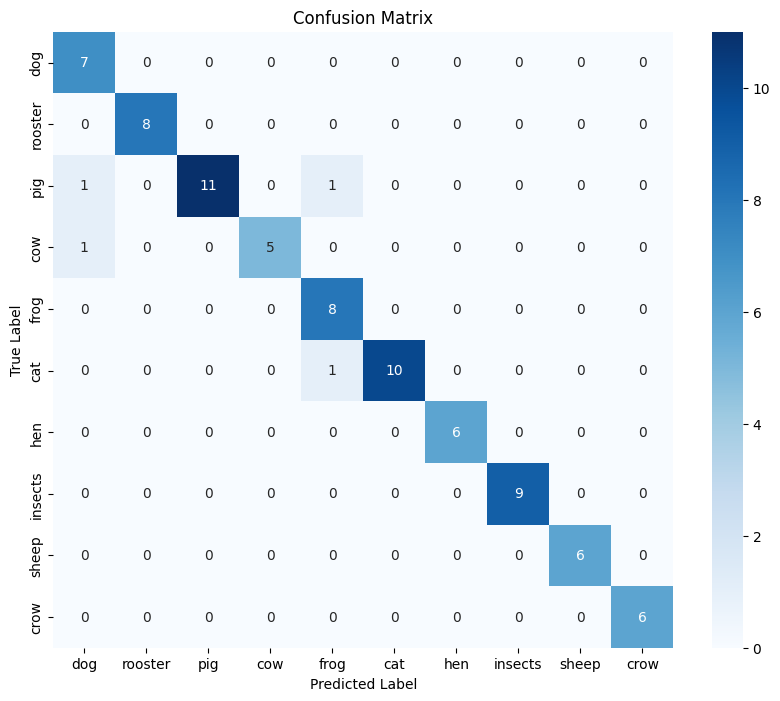

In [44]:
# confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=animals, yticklabels=animals)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [45]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=animals))

Classification Report:

              precision    recall  f1-score   support

         dog       0.78      1.00      0.88         7
     rooster       1.00      1.00      1.00         8
         pig       1.00      0.85      0.92        13
         cow       1.00      0.83      0.91         6
        frog       0.80      1.00      0.89         8
         cat       1.00      0.91      0.95        11
         hen       1.00      1.00      1.00         6
     insects       1.00      1.00      1.00         9
       sheep       1.00      1.00      1.00         6
        crow       1.00      1.00      1.00         6

    accuracy                           0.95        80
   macro avg       0.96      0.96      0.95        80
weighted avg       0.96      0.95      0.95        80



#One Function

In [81]:
# one function to preprocess and predict

def full_vggish(filename):
    # preprocess the .wav file
    esc_waveform = preprocess_wav('audio/' + filename)

    # run VGGish and get the embedding
    score, embedding, spectrogram = yamnet(esc_waveform)
    embedding = np.expand_dims(embedding, axis=0)

    # use the full classification model
    predictions =  model.predict(embedding)

    # Get the predicted class label
    predicted_label_index = np.argmax(predictions[0])
    predicted_label = lb.classes_[predicted_label_index]

    print(f"Predicted Category: {predicted_label}")

    # get the true category
    category = esc50_animals[esc50_animals['filename'] == filename]['category'].values[0]
    print(f"True Category: {category}")

In [84]:
full_vggish(esc50_animals.iloc[120]['filename'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Category: pig
True Category: pig
